In [93]:
import os
import sys
from pathlib import Path
from configparser import ConfigParser

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

# Setup notebook
nbconfig = Nb.setup_notebook(subproject_dir='../output/FlyMeeting_2018_poster', formats=['png', 'pdf'], styles=['notebook', 'poster'])

# Connect to data store
store = pd.HDFStore('../sra.h5', mode='r')

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-04-08 
Git hash: 9b8b788ea8c41c64ba111a5698eead9fecb7a1ca


In [3]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27022)
db = mongoClient['sra']
ncbi = db['ncbi']

In [4]:
# Constants
from ncbi_remap.prealn_analysis import (LIBSIZE_CUTOFF, READLEN_CUTOFF, STRAND_CUTOFF1, 
    STRAND_CUTOFF2, UNALIGN_CUTOFF, CONTAMINATION_CUTOFF)

REFERENCES = [
    'phix', 
    'ercc', 
    'dm6', 
    'wolbachia', 
    'yeast', 
    'ecoli', 
    'hg19',
]

complete = store['prealn/complete']
num_samples = complete.shape[0]

In [5]:
c1 = '#1c5379'
c2 = '#0078A4'
c3 = '#A6D3EB'
c4 = '#F1F7E5'
c5 = '#E5901A'

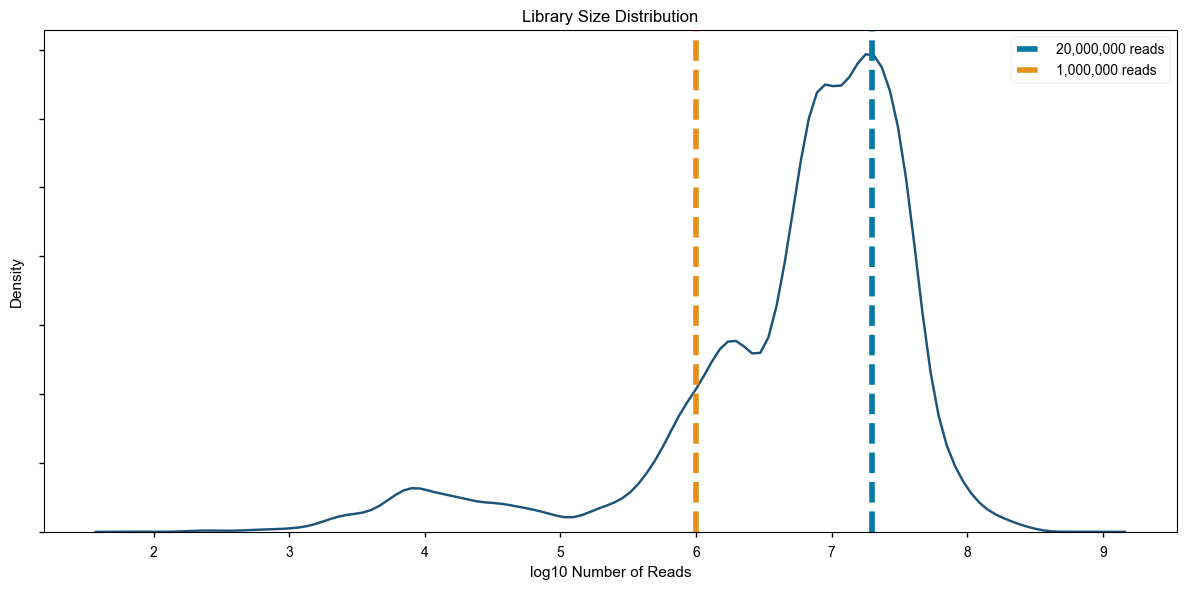

In [5]:
@make_figs(nbconfig.fig_name('distplot_libsize'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot(store):
    sr = store['prealn/workflow/fastq']['libsize_R1']
    fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
    sns.distplot(np.log10(sr), ax=ax, color=c1, hist=False)
    ax.axvline(np.log10(2e7), ls='--', lw=4, color=c2, label='20,000,000 reads')
    ax.axvline(np.log10(1e6), ls='--', lw=4, color=c5, label='1,000,000 reads')
    ax.legend()
    ax.set_xlabel('log10 Number of Reads')
    ax.set_ylabel('Density')
    ax.set_title('Library Size Distribution');
    ax.set_yticklabels([])
    return fig

plot(store)

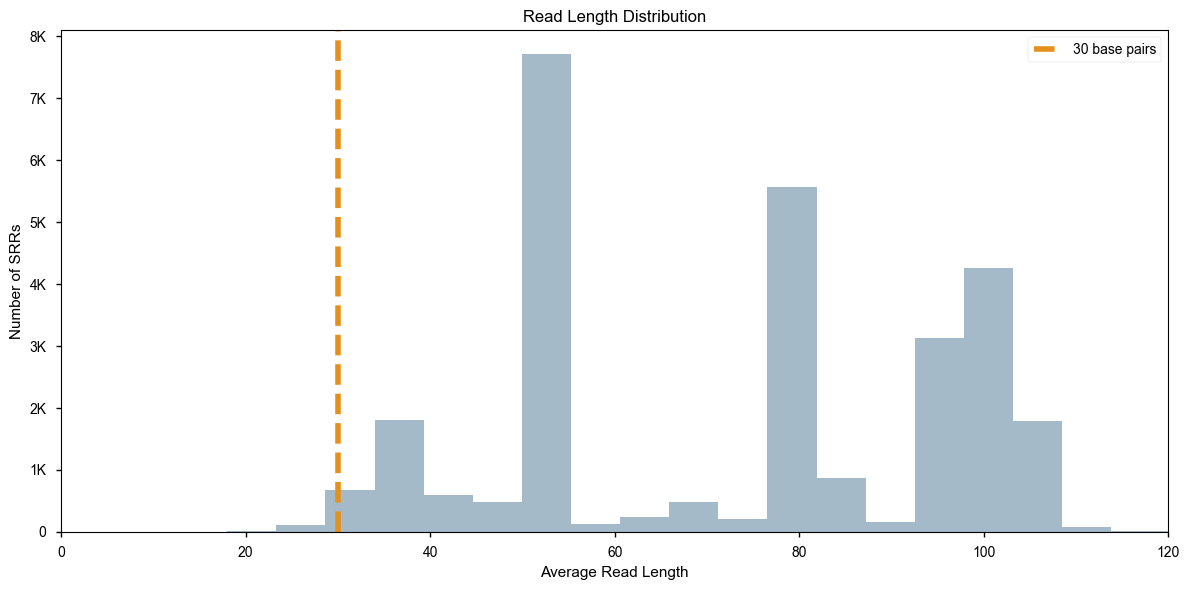

In [6]:
# Plot distribution of read lengths
@make_figs(nbconfig.fig_name('distplot_readLen'), 
           styles=nbconfig.styles, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq'][['avgLen_R1', 'avgLen_R2']]
    df['len'] = df[['avgLen_R1', 'avgLen_R2']].max(axis=1)

    fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
    sns.distplot(df.len, bins=200, ax=ax, color=c1, kde=False, hist_kws={"align": 'right'})
    ax.set_xlabel('Average Read Length')
    ax.set_ylabel('Number of SRRs')
    ax.set_xlim(0, 120)
    ax.set_title('Read Length Distribution');
    ax.axvline(READLEN_CUTOFF, ls='--', lw=4, color=c5, label='{} base pairs'.format(READLEN_CUTOFF))
    ax.legend()
    
    labels = []
    for t in ax.get_yticks():
        if t == 0:
            labels.append('0')
        else:
            labels.append(str(t)[0] + 'K')
            
    ax.set_yticklabels(labels)
    
    return fig

plot(store)

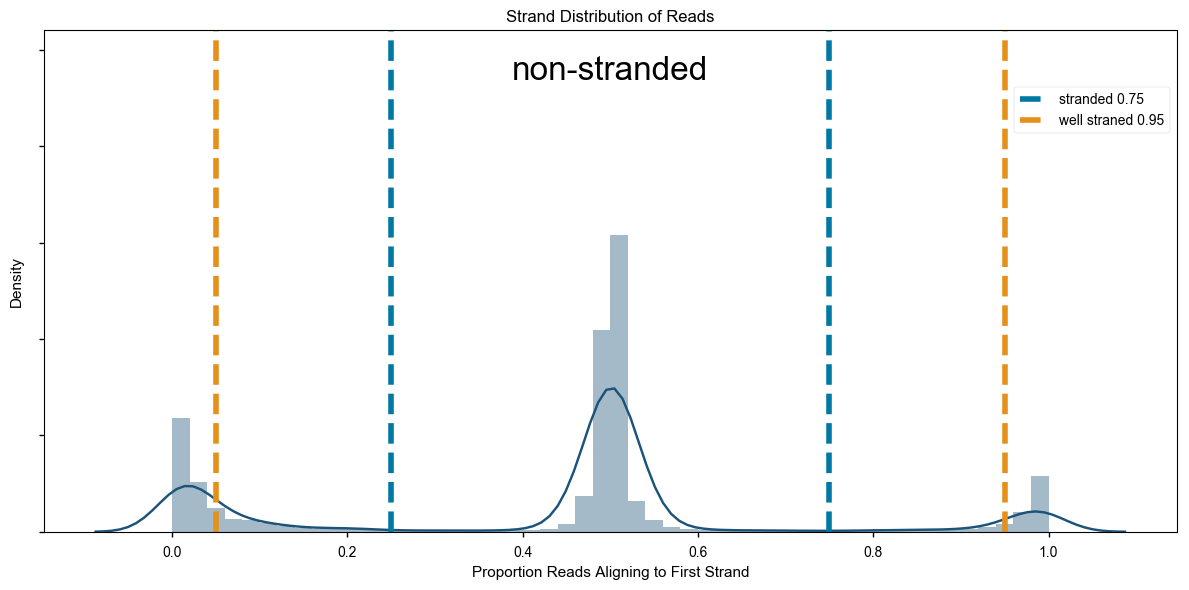

In [7]:
@make_figs(nbconfig.fig_name('distplot_strandedness'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/collectrnaseqmetrics/first']
    
    fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
    sns.distplot(df.PCT_CORRECT_STRAND_READS, ax=ax, color=c1)
    ax.set_title('Strand Distribution of Reads')
    ax.set_xlabel('Proportion Reads Aligning to First Strand')
    ax.set_ylabel('Density')
    ax.axvline(STRAND_CUTOFF1, ls='--', lw=4, color=c2, label='stranded {:.2f}'.format(STRAND_CUTOFF1))
    ax.axvline(1 - STRAND_CUTOFF1, ls='--', lw=4, color=c2)
    ax.axvline(STRAND_CUTOFF2, ls='--', lw=4, color=c5, label='well straned {:.2f}'.format(STRAND_CUTOFF2))
    ax.axvline(1 - STRAND_CUTOFF2, ls='--', lw=4, color=c5)

    ax.text(.5, .9, 'non-stranded', ha='center', fontdict={'size': 24}, transform=ax.transAxes)
    ax.set_ylim(0, 26)
    ax.set_yticklabels([])
    ax.legend(loc='upper right', bbox_to_anchor=(1, .9), facecolor='w', frameon=True, framealpha=1)
    return fig

plot(store)

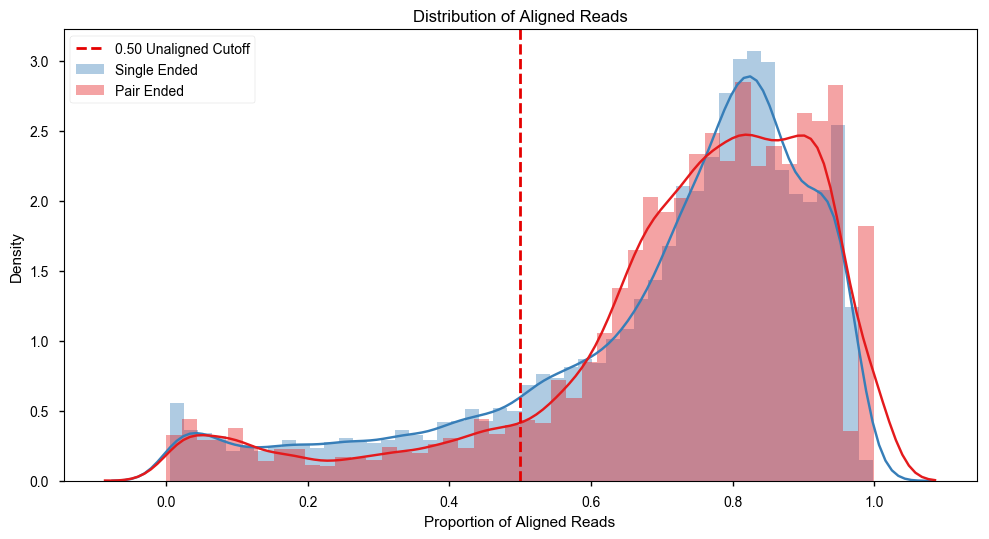

In [8]:
# Plot distribution of unmapped reads.
@make_figs(nbconfig.fig_name('distplot_unaligned'), styles=nbconfig.styles_wide, 
           formats=nbconfig.formats)
def plot(store):
    se = store['prealn/workflow/hisat2'][['num_reads', 'num_reads_unpaired', 'num_unaligned']]
    se.dropna(inplace=True)
    se['prop_aligned'] = 1 - (se['num_unaligned'] / se['num_reads'])

    pe = store['prealn/workflow/hisat2'][['num_reads', 'num_reads_paired', 'num_concordant_reads_unaligned']]
    pe.dropna(inplace=True)
    pe['prop_aligned'] = 1 - (pe['num_concordant_reads_unaligned'] / pe['num_reads'])

    fig, ax = plt.subplots(1, 1)
    sns.distplot(se.prop_aligned, ax=ax, label='Single Ended')
    sns.distplot(pe.prop_aligned, ax=ax, label='Pair Ended')
    ax.axvline(UNALIGN_CUTOFF, color=nbconfig.color_c1, ls='--', lw=2, label='{:0.2f} Unaligned Cutoff'.format(UNALIGN_CUTOFF))
    ax.legend()
    ax.set_title('Distribution of Aligned Reads')
    ax.set_xlabel('Proportion of Aligned Reads')
    ax.set_ylabel('Density');
    
plot(store)

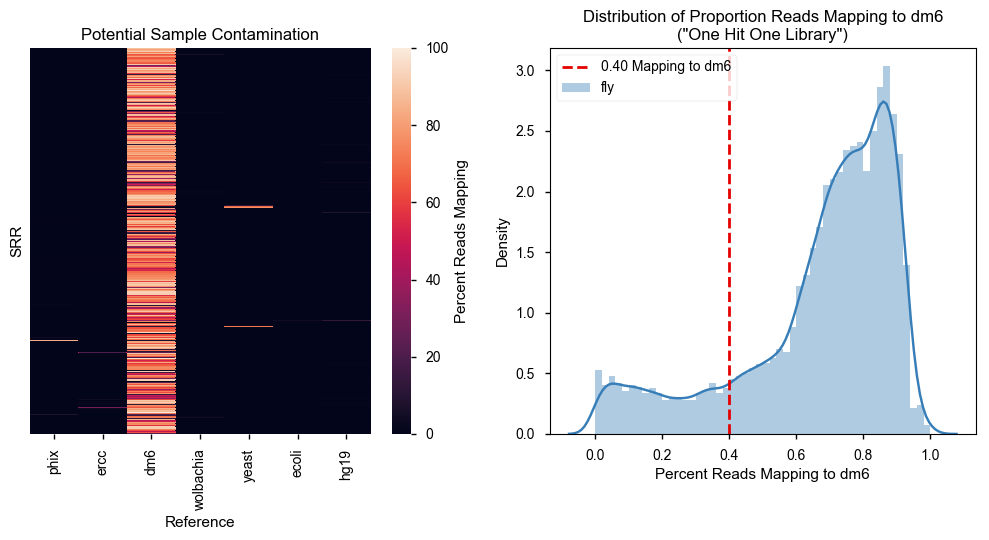

In [9]:
# Plot heatmap of one hit one species
@make_figs(nbconfig.fig_name('heatmap_distplot_contamination'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = store['prealn/workflow/fastq_screen']
    df.reset_index(inplace=True)
    df = df[['srx', 'srr', 'reference', 'one_hit_one_library_percent']].set_index(['srx', 'srr', 'reference']).dropna().unstack()
    df.columns = df.columns.droplevel(0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.heatmap(df[REFERENCES], yticklabels=False, cbar_kws={'label': 'Percent Reads Mapping'}, ax=ax1)
    ax1.set_title('Potential Sample Contamination');
    ax1.set_ylabel('SRR');
    ax1.set_xlabel('Reference');

    # Plot distirbution of major categories
    sns.distplot(df.dm6 / 100, label='fly', ax=ax2)
    plt.title('Distribution of Proportion Reads Mapping to dm6\n("One Hit One Library")');
    ax2.set_xlabel('Percent Reads Mapping to dm6')
    ax2.set_ylabel('Density')
    ax2.axvline(CONTAMINATION_CUTOFF / 100, color=nbconfig.color_c1, ls='--', lw=2, 
                label='{:0.2f} Mapping to dm6'.format(CONTAMINATION_CUTOFF / 100))
    ax2.legend()
    
    return fig

plot(store)

In [34]:
dat = store['prealn/workflow/collectrnaseqmetrics/genebody'].groupby('srx').median()
dat.columns = [x.strip('pos_') for x in dat.columns]
srxs = dat.index.tolist()

strat = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': srxs}

        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$_id',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    },
])))

strat.set_index('srx', inplace=True)

mapper = {
    'OTHER': 'OTHER', 
    'WGS': 'WGS', 
    'EST': 'EST', 
    'RNA-Seq': 'RNA-Seq', 
    'AMPLICON': 'OTHER', 
    'ChIP-Seq': 'ChIP-Seq',
    'miRNA-Seq': 'OTHER', 
    'MNase-Seq': 'OTHER', 
    'FL-cDNA': 'OTHER', 
    'RIP-Seq': 'OTHER', 
    'CLONE': 'OTHER', 
    'CLONEEND': 'OTHER',
    'ncRNA-Seq': 'OTHER', 
    'Bisulfite-Seq': 'OTHER', 
    'POOLCLONE': 'OTHER', 
    'DNase-Hypersensitivity': 'OTHER',
    'FAIRE-seq': 'OTHER', 
    'WGA': 'OTHER', 
    'MeDIP-Seq': 'OTHER'
}

strat = strat.library_strategy.map(lambda x: mapper[x])
_sort = strat.sort_values().index.tolist()
pal = sns.color_palette('tab20', n_colors=strat.unique().size)
lut = dict(zip(strat.unique(), pal))
cmap = strat.map(lambda x: lut[x])

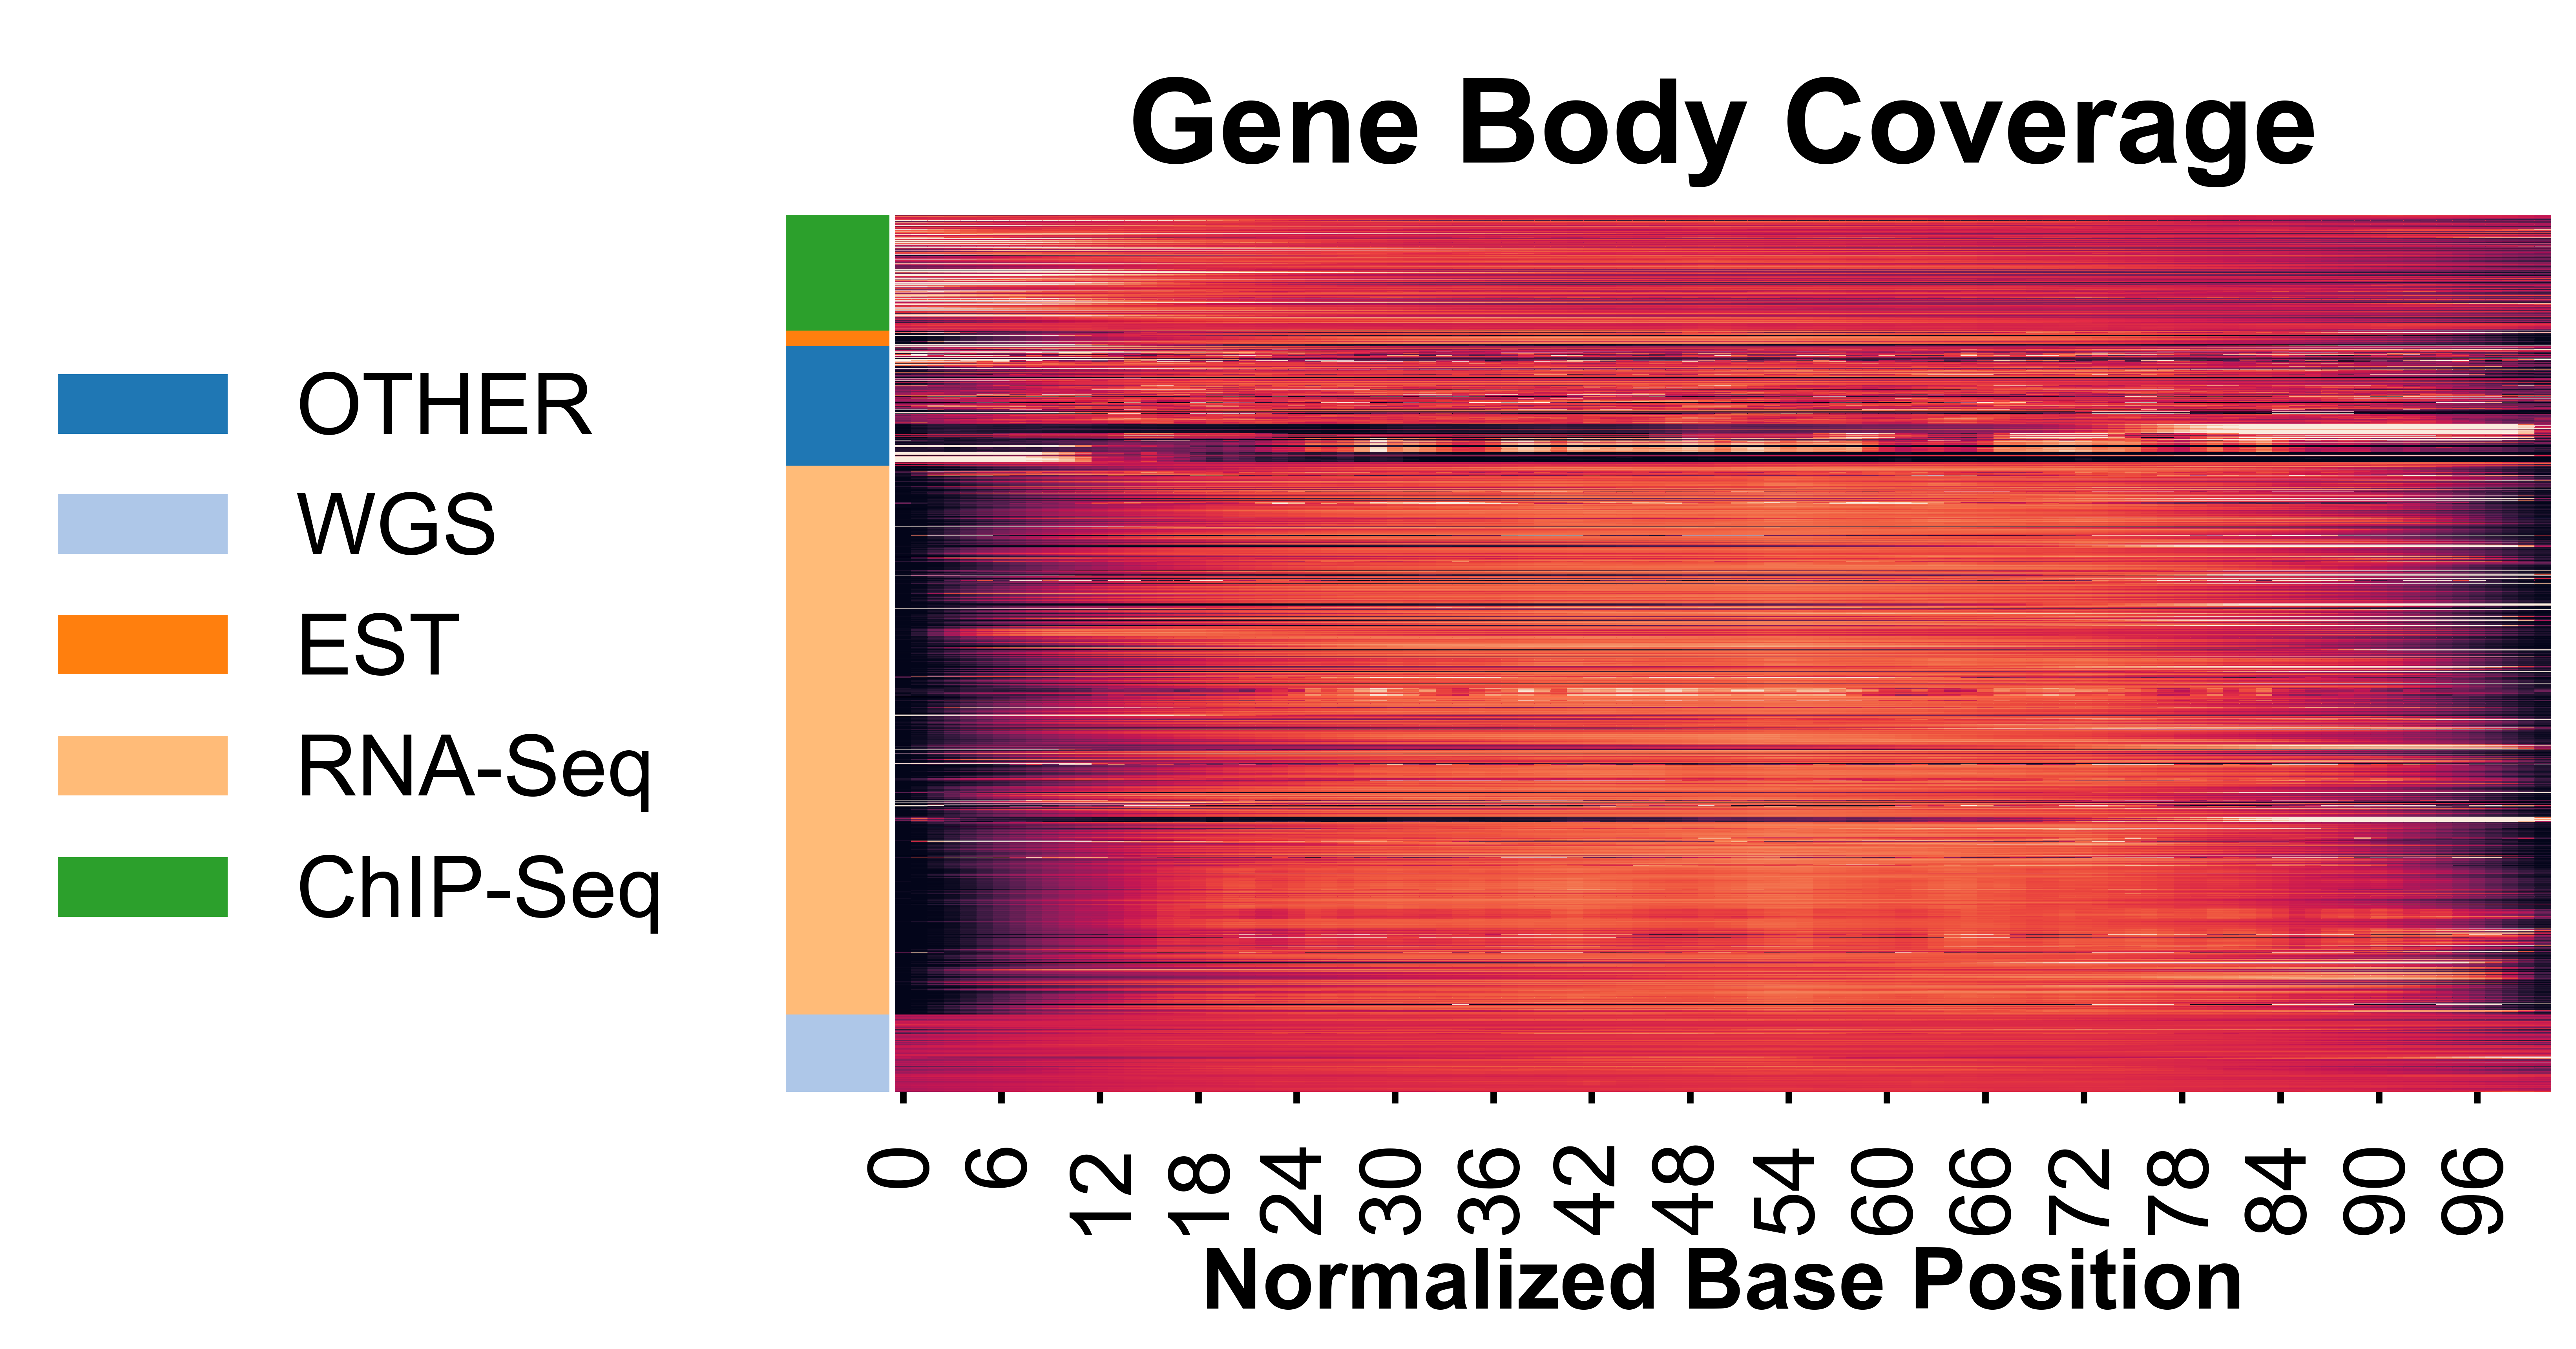

In [35]:
def _plot():
    g = sns.clustermap(
        dat.loc[_sort], 
        robust=True, 
        yticklabels=False, 
        col_cluster=False, 
        row_cluster=False, 
        figsize=plt.figaspect(1/2),
        row_colors=cmap,
        rasterized=True,
    )

    # Color bar labels
    for label in strat.unique():
        g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    g.ax_row_dendrogram.legend(loc='center', bbox_to_anchor=[0, .5])
    g.ax_row_colors.set_xticklabels([])
    g.ax_row_colors.set_xticks([])
    
    # Tick labels
    new = []
    for l in g.ax_heatmap.get_xticklabels():
        l.set_rotation(90)
        new.append(l)
        
    g.ax_heatmap.set_xticklabels(new)
        

    g.ax_heatmap.set_xlabel('Normalized Base Position')
    g.ax_heatmap.set_ylabel('')
    g.ax_heatmap.set_title('Gene Body Coverage')
    g.cax.set_visible(False)
    
    return g

with mpl.style.context(['common', 'poster']):
    g = _plot()
    g.savefig(nbconfig.fig_name('heatmap_gene_body_coverage_poster') + '.pdf')
    g.savefig(nbconfig.fig_name('heatmap_gene_body_coverage_poster') + '.png')

In [96]:
srxs = store['aln/complete'].srx.unique().tolist()
second = store['prealn/workflow/collectrnaseqmetrics/second'].query(f'srx in {srxs}')
srxs = second.query('PCT_CORRECT_STRAND_READS > .95 & PCT_MRNA_BASES > .98')\
    .sort_values(by='PF_ALIGNED_BASES', ascending=False).head(5).index.get_level_values('srx').tolist()

In [98]:
config = ConfigParser()

config['x-axis'] = {}
config['spacer'] = {}

for srx in srxs:
    config[f'{srx}.first'] = {
        'file': f'output/samples/{srx}/{srx}.first.bw',
        'title': f'{srx}',
        'height': 1,
        'color': '#0000ff80',
        'min_value': 0,
        'max_value': 10,
        'number of bins': 500,
        'nans to zeros': True,
        'show data range': 'yes',
        'file_type': 'bigwig',
    }

    config[f'{srx}.second'] = {
        'file': f'output/samples/{srx}/{srx}.second.bw',
        'overlay previous': 'yes',
        'height': 1,
        'color': '#ff000080',
        'min_value': 0,
        'max_value': 10,
        'number of bins': 500,
        'nans to zeros': True,
        'show data range': 'no',
        'file_type': 'bigwig',
    }

config['spacer'] = {}

config['dmel_r6-11'] = {
    'file': 'dmel_r6-11.sort.bed12',
    'title': 'genes',
    'height': 2,
    'color': 'darkblue',
    'height': 5,
    'labels': 'on',
    'fontsize': 10,
    'style': 'flybase',
    'file_type': 'bed',
}

with open("../aln-wf/output/well_stranded_5.ini", 'w') as fh:
    config.write(fh)

In [99]:
srxs = store['aln/complete'].srx.unique().tolist()
second = store['prealn/workflow/collectrnaseqmetrics/second'].query(f'srx in {srxs}')
srxs = second.query('PCT_CORRECT_STRAND_READS > .95 & PCT_MRNA_BASES > .98')\
    .sort_values(by='PF_ALIGNED_BASES', ascending=False).head(20).index.get_level_values('srx').tolist()

In [106]:
config = ConfigParser()

config['x-axis'] = {}
config['spacer'] = {}

for srx in srxs:
    config[f'{srx}.first'] = {
        'file': f'output/samples/{srx}/{srx}.first.bw',
        'title': f'{srx}',
        'height': 1,
        'color': '#0000ff80',
        'min_value': 0,
        'max_value': 'auto',
        'number of bins': 500,
        'nans to zeros': True,
        'show data range': 'yes',
        'file_type': 'bigwig',
    }

    config[f'{srx}.second'] = {
        'file': f'output/samples/{srx}/{srx}.second.bw',
        'overlay previous': 'yes',
        'height': 1,
        'color': '#ff000080',
        'min_value': 0,
        'max_value': 'auto',
        'number of bins': 500,
        'nans to zeros': True,
        'show data range': 'no',
        'file_type': 'bigwig',
    }

with open("../aln-wf/output/well_stranded_20.ini", 'w') as fh:
    config.write(fh)

In [112]:
srxs = second.index.get_level_values('srx').tolist()

In [124]:
papers = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': srxs},
            'pubmed.pubmed_id': {'$exists': 1}
        }
    },
    {
        '$project':{
            '_id': 0,
            'srx': '$_id',
            'pubmed': {'$arrayElemAt': ['$pubmed.pubmed_id', 0]}
        }
    }
])))

papers.set_index('srx', inplace=True)

In [127]:
cnts = papers.groupby('pubmed').size().sort_values(ascending=False)

In [139]:
pmid = cnts[cnts == 5].index[0]

In [142]:
srxs = papers.query(f'pubmed == "{pmid}"').index.tolist()

In [144]:
config = ConfigParser()

config['x-axis'] = {}
config['spacer'] = {}

for srx in srxs:
    config[f'{srx}.first'] = {
        'file': f'output/samples/{srx}/{srx}.first.bw',
        'title': f'{pmid} ({srx})',
        'height': 1,
        'color': '#0000ff80',
        'min_value': 0,
        'max_value': 'auto',
        'number of bins': 500,
        'nans to zeros': True,
        'show data range': 'yes',
        'file_type': 'bigwig',
    }

    config[f'{srx}.second'] = {
        'file': f'output/samples/{srx}/{srx}.second.bw',
        'overlay previous': 'yes',
        'height': 1,
        'color': '#ff000080',
        'min_value': 0,
        'max_value': 'auto',
        'number of bins': 500,
        'nans to zeros': True,
        'show data range': 'no',
        'file_type': 'bigwig',
    }

config['spacer'] = {}

config['dmel_r6-11'] = {
    'file': 'dmel_r6-11.sort.bed12',
    'title': 'genes',
    'height': 2,
    'color': 'darkblue',
    'height': 5,
    'labels': 'on',
    'fontsize': 10,
    'style': 'flybase',
    'file_type': 'bed',
}

with open("../aln-wf/output/by_paper.ini", 'w') as fh:
    config.write(fh)

In [148]:
config = ConfigParser()

config['x-axis'] = {}
config['spacer'] = {}

config[f'agg.first'] = {
    'file': f'output/first.bw',
    'title': f'Well Stranded Aggregation (n=4,900)',
    'height': 3,
    'color': '#0000ff80',
    'min_value': 0,
    'max_value': 'auto',
    'number of bins': 500,
    'nans to zeros': True,
    'show data range': 'yes',
    'file_type': 'bigwig',
}

config[f'agg.second'] = {
    'file': f'output/second.bw',
    'overlay previous': 'yes',
    'height': 3,
    'color': '#ff000080',
    'min_value': 0,
    'max_value': 'auto',
    'number of bins': 500,
    'nans to zeros': True,
    'show data range': 'no',
    'file_type': 'bigwig',
}

config['spacer'] = {}

config['dmel_r6-11'] = {
    'file': 'dmel_r6-11.sort.bed12',
    'title': 'genes',
    'height': 1,
    'color': 'darkblue',
    'labels': 'on',
    'fontsize': 10,
    'style': 'flybase',
    'file_type': 'bed',
}

with open("../bigwig-wf/output/aggregated.ini", 'w') as fh:
    config.write(fh)

In [154]:
srxs = store['aln/complete'].srx.unique().tolist()
rnaseq = [x['_id'] for x in ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': srxs},
            'sra.experiment.library_strategy': 'RNA-Seq'
        }
    },
    {
        '$project': {
            '_id': 1
        }
    }
])]

In [156]:
sxl = nbconfig.symbol2fbgn['Sxl']

In [169]:
values = {}
for srx in rnaseq:
    try:
        df = pd.read_parquet(f'../aln-wf/output/gene_counts/{srx}.parquet')
        values[srx] = df.loc[sxl, 'count']
    except:
        pass

In [170]:
sxlSr = pd.Series(values)

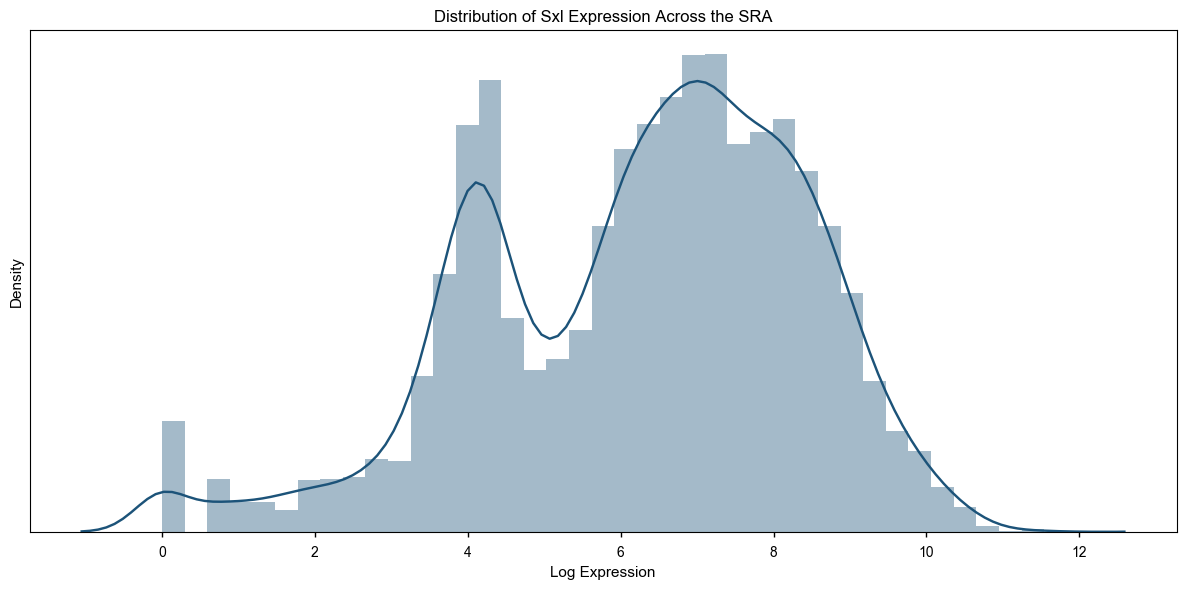

In [178]:
# Plot distribution of unmapped reads.
@make_figs(nbconfig.fig_name('distplot_sxl'), styles=nbconfig.styles, formats=nbconfig.formats)
def plot():
    fig, ax = plt.subplots(1, 1, figsize=plt.figaspect(1/2))
    sns.distplot(np.log1p(sxlSr), color=c1, ax=ax)
    ax.set_title('Distribution of Sxl Expression Across the SRA')
    ax.set_xlabel('Log Expression')
    ax.set_ylabel('Density')
    ax.set_yticklabels([])
    ax.set_yticks([])
    
plot()